In [6]:
# !git clone https://github.com/quangdaist/Short-Video-Recommendation.git
!mkdir Short-Video-Recommendation || true
%cd /content/Short-Video-Recommendation/
!git init
!git remote add origin https://github.com/quangdaist/Short-Video-Recommendation.git || true
!git fetch origin
!git reset --hard origin/main
!git checkout origin/main

/content/Short-Video-Recommendation
Reinitialized existing Git repository in /content/Short-Video-Recommendation/.git/
fatal: remote origin already exists.
HEAD is now at 904b628 raw model results
HEAD is now at 904b628 raw model results


In [7]:
# %%capture
%cd /content/Short-Video-Recommendation/models/deepctr_torch
!pip install -e .
!pip install rtdl
!pip install zero

/content/Short-Video-Recommendation/models/deepctr_torch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/Short-Video-Recommendation/models/deepctr_torch
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepctr-torch
    Found existing installation: deepctr-torch 0.2.9
    Can't uninstall 'deepctr-torch'. No files were found to uninstall.
  Running setup.py develop for deepctr-torch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Demo Adaptive beam search

In [8]:
%cd /content/Short-Video-Recommendation
# Import libraries
import cv2
from matplotlib import pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

import time
import requests
from requests.adapters import HTTPAdapter, Retry
import json
import os
import glob
import argparse

import sys

sys.path.append(r'C:\Users\MSI I5\PycharmProjects\Short-Video-Recommendation\models\Multitask-Recommendation-Library')
sys.path.append('/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library')
sys.path.append('/content/Short-Video-Recommendation')

import pandas as pd
from models.omoe import OMoEModel
from models.mmoe import MMoEModel
from models.ple import PLEModel
from models.aitm import AITMModel
from models.metaheac import MetaHeacModel

from datasets.aliexpress import AliExpressDataset
from datasets.my_dataset import MyDataset

import tqdm
import torch
from torch.utils.data import DataLoader


def calculate_list_reward(permutation, alpha=0.5, beta=0.5):
    s = [1]
    for i in range(1, len(permutation)):
        s_i = 1
        for j in range(0, i):
            p_effective_view = permutation[j][1][1]
            s_i *= p_effective_view
        s.append(s_i)

    list_reward = 0
    for i in range(len(permutation)):
        reward = s[i] * (alpha * permutation[0][1][0] + beta * permutation[0][1][2])
        list_reward += reward

    return list_reward


def get_indices_from_permutation(permutation):
    indices = []
    for pair in permutation[0]:
        indices.append(pair[0])
    return indices


def get_list_reward_from_permutation(permutation):
    return permutation[1]


def calculate_stability_from_beam_scores(beam_scores):
    return min(beam_scores) / max(beam_scores)


def create_a_series_with_filled_candidates_and_empty_target_features(watched_candidates_indices, beam_indices, candidate_features_list, many_candidate_features_column_names,
                                                                     target_features_column_names):
    temp = df_test.iloc[0, :].copy()
    temp[target_features_column_names] = 0
    row_series_with_empty_candidates_and_target_features = temp

    # Fill watched candidate
    for watched_candidate_position, watched_candidate_index in enumerate(watched_candidates_indices, start=0):
        # Fill candidate videos' features
        candidate_features_column_names = many_candidate_features_column_names[watched_candidate_position]
        candidate_features_value = candidate_features_list[watched_candidate_index]
        row_series_with_empty_candidates_and_target_features[candidate_features_column_names] = candidate_features_value

    unfilled_candidate_position = len(watched_candidates_indices)

    for candidate_position, beam_index in enumerate(beam_indices, start=unfilled_candidate_position):
        # Fill candidate videos' features
        candidate_features_column_names = many_candidate_features_column_names[candidate_position]
        candidate_features_value = candidate_features_list[beam_index]
        row_series_with_empty_candidates_and_target_features[candidate_features_column_names] = candidate_features_value

    return row_series_with_empty_candidates_and_target_features


def create_df_input(target_video_indices, a_series_with_filled_candidates_and_empty_target_features, candidate_features_list, target_features_column_names, columns):
    """

    :param target_video_indices:
    :param a_series_with_filled_candidates_and_empty_target_features:
    :param candidate_features_list:
    :return: a DataFrame
    """

    df_empty = pd.DataFrame(columns=columns)
    # Fill target video features
    for target_video_index in target_video_indices:
        target_features_value = candidate_features_list[target_video_index][:3]
        a_series_with_filled_candidates_and_empty_target_features[target_features_column_names] = target_features_value
        df_empty = df_empty.append(a_series_with_filled_candidates_and_empty_target_features)

    df_new = df_empty
    df_new.fillna(0, inplace=True)
    return df_new


def get_dataset(df):
    return MyDataset(df)


def load_model(name, dataset, path):
    """
    Hyperparameters are empirically determined, not opitmized.
    """

    categorical_field_dims = dataset.field_dims
    numerical_num = dataset.numerical_num
    expert_num = 8
    task_num = 3
    embed_dim = 128
    if name == 'omoe':
        print("Model: OMoE")
        model = OMoEModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, expert_num=expert_num, dropout=0.2)
    elif name == 'mmoe':
        print("Model: MMoE")
        model = MMoEModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, expert_num=expert_num, dropout=0.2)
    elif name == 'ple':
        print("Model: PLE")
        model = PLEModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, shared_expert_num=int(expert_num / 2), specific_expert_num=int(expert_num / 2), dropout=0.2)
    elif name == 'aitm':
        print("Model: AITM")
        model = AITMModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, dropout=0.2)
    elif name == 'metaheac':
        print("Model: MetaHeac")
        model = MetaHeacModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, expert_num=expert_num, critic_num=5, dropout=0.2)
    else:
        model = torch.load(path)
        return model

    model.load_state_dict(torch.load(path))
    return model


def get_predictions(model, df_model_input, model_name, feature_names, device):
    """

    :param model:
    :param df_model_input:
    :return: list of lists
    """

    if model_name.lower() in ['singletask', 'sharedbottom', 'omoe', 'mmoe', 'ple', 'aitm', 'metaheac']:
        test_dataset = get_dataset(df_model_input)
        test_data_loader = DataLoader(test_dataset, batch_size=7, num_workers=4, shuffle=False)

        predicts_dict = {}
        task_num = 3
        for i in range(task_num):
            predicts_dict[i] = list()
        with torch.no_grad():
            for categorical_fields, numerical_fields, labels in tqdm.tqdm(test_data_loader, smoothing=0, mininterval=1.0, disable=True):
                categorical_fields, numerical_fields, labels = categorical_fields.to(device), numerical_fields.to(device), labels.to(device)
                y = model(categorical_fields, numerical_fields)
                for i in range(task_num):
                    predicts_dict[i].extend(y[i].tolist())

        pred_ans = list(zip(predicts_dict[0], predicts_dict[1], predicts_dict[2]))
        # Convert list of tuples => list of lists
        pred_ans = [list(item) for item in pred_ans]
    else:
        test_model_input = {name: df_model_input[name] for name in feature_names}
        pred_ans = model.predict(test_model_input, 7)
        pred_ans = pred_ans.tolist()
    return pred_ans


def download_thumbnail(url):
    video_id = re.findall('(?<=video\/)(.*?)(?=\?)', url)[0]

    headers = {
            'sec-ch-ua': '"Not?A_Brand";v="8", "Chromium";v="108", "Microsoft Edge";v="108"',
            'Referer': 'https://snaptik.app/',
            'DNT': '1',
            'sec-ch-ua-mobile': '?0',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36 Edg/108.0.1462.54',
            'sec-ch-ua-platform': '"Windows"',
    }

    response = requests.get(
            f'https://www.tiktok.com/oembed?url=https://www.tiktok.com/@tiktok/video/{video_id}',
            headers=headers,
    )

    vid_info = json.loads(response.text)
    thumb_url = vid_info['thumbnail_url']
    thumb_fname = f"{THUMBNAILS_PATH}/{video_id}.png"
    # print(thumb_fname)
    r = requests.get(thumb_url)
    with open(thumb_fname, 'wb') as outfile:
        outfile.write(r.content)

    print(f'Video id: {video_id} => Done')
    return thumb_fname


def draw_green_bbox(ax):
    fig = ax.get_figure()
    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))
    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))
    rect = plt.Rectangle(
            (x0, y0), x1 - x0, y1 - y0,
            color='g',
            transform=ax.transAxes,
            zorder=-1,
            lw=2 * 4 + 4,
            fill=None,
    )
    fig.patches.append(rect)

def display_candidate_thumbnails(new_candidate_order, many_thumbnail_paths, watched_candidates_indices, model_name):
    index_of_next_video_to_show = new_candidate_order[0]

    for _ in watched_candidates_indices:
        new_candidate_order = [-1] + new_candidate_order

    # create figure
    fig = plt.figure(figsize=(10, 7))
    fig.suptitle(model_name, fontsize=25)

    # setting values to rows and column variables
    rows = 1
    columns = 5
    # reading images
    images = []
    for index in new_candidate_order:
        if index == -1:
            image = cv2.imread(blank_image_path)
        else:
            image = cv2.imread(many_thumbnail_paths[index])
            image = image[:, :, ::-1]
        images.append(image)

    # Showing image
    for index, image in enumerate(images, start=1):
        ax = fig.add_subplot(rows, columns, index)

        if index - 1 == len(watched_candidates_indices):
            draw_green_bbox(ax)

        plt.imshow(image)
        plt.axis('off')
        if index == 5:
            break
    fig.tight_layout()
    fig.subplots_adjust(top=1.35)



# %%
THUMBNAILS_PATH = 'thumbnails_for_demo'

columns = ["uid", "w1_duration", "w1_num_likes", "w1_num_comments", "w1_watched_time", "w1_like", "w2_duration", "w2_num_likes", "w2_num_comments", "w2_watched_time", "w2_like", "w3_duration",
           "w3_num_likes", "w3_num_comments", "w3_watched_time", "w3_like", "w4_duration", "w4_num_likes", "w4_num_comments", "w4_watched_time", "w4_like", "w5_duration", "w5_num_likes",
           "w5_num_comments",
           "w5_watched_time", "w5_like", "w6_duration", "w6_num_likes", "w6_num_comments", "w6_watched_time", "w6_like", "w7_duration", "w7_num_likes", "w7_num_comments", "w7_watched_time", "w7_like",
           "w8_duration", "w8_num_likes", "w8_num_comments", "w8_watched_time", "w8_like", "w9_duration", "w9_num_likes", "w9_num_comments", "w9_watched_time", "w9_like", "w10_duration",
           "w10_num_likes", "w10_num_comments", "w10_watched_time", "w10_like", "c1_duration", "c1_num_likes", "c1_num_comments", "c2_duration", "c2_num_likes", "c2_num_comments", "c3_duration",
           "c3_num_likes", "c3_num_comments", "c4_duration", "c4_num_likes", "c4_num_comments", "t1_duration", "t1_num_likes", "t1_num_comments", "p_like", "p_has_next", "p_effective_view",
           "target_url"]

df_test = pd.read_csv('./dataset/final_input/final_test_with_urls.csv', header=0)
df_test = df_test.drop(['uid'], axis=1)

df_train = pd.read_csv('dataset/final_input/final_train.csv', header=0)
df_train = df_train.drop(['uid'], axis=1)


columns.remove('uid')

target_urls = df_test['target_url'].tolist()

df_test = df_test.drop(['target_url'], axis=1)
columns.remove('target_url')

sparse_features = [f'w{i}_like' for i in range(1, 11)]
target = ["p_like", "p_has_next", "p_effective_view"]
dense_features = [feature for feature in columns if feature in list(set(columns) - set(sparse_features) - set(target))]

for column in columns:
    df_test[column] = df_test[column].astype('float')
    df_train[column] = df_train[column].astype('float')

# Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    df_test[feat] = lbe.fit_transform(df_test[feat])    
    df_train[feat] = lbe.fit_transform(df_train[feat])


mms = MinMaxScaler(feature_range=(0, 1))
df_test[dense_features] = mms.fit_transform(df_test[dense_features])
df_train[dense_features] = mms.fit_transform(df_train[dense_features])

# Count #unique features for each sparse field,and record dense feature field name
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=df_train[feat].max() + 1, embedding_dim=8)
                          for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                          for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(
        linear_feature_columns + dnn_feature_columns)


def get_dataset(df):
    return MyDataset(df)


def load_model(name, dataset, path):
    """
    Hyperparameters are empirically determined, not opitmized.
    """

    categorical_field_dims = dataset.field_dims
    numerical_num = dataset.numerical_num
    expert_num = 8
    task_num = 3
    embed_dim = 128
    name = name.lower()
    if name == 'omoe':
        print("Model: OMoE")
        model = OMoEModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, expert_num=expert_num, dropout=0.2)
    elif name == 'mmoe':
        print("Model: MMoE")
        model = MMoEModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, expert_num=expert_num, dropout=0.2)
    elif name == 'ple':
        print("Model: PLE")
        model = PLEModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, shared_expert_num=int(expert_num / 2), specific_expert_num=int(expert_num / 2), dropout=0.2)
    elif name == 'aitm':
        print("Model: AITM")
        model = AITMModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, dropout=0.2)
    elif name == 'metaheac':
        print("Model: MetaHeac")
        model = MetaHeacModel(categorical_field_dims, numerical_num, embed_dim=embed_dim, bottom_mlp_dims=(512, 256), tower_mlp_dims=(128, 64), task_num=task_num, expert_num=expert_num, critic_num=5, dropout=0.2)
    else:
        model = torch.load(path)
        return model

    model.load_state_dict(torch.load(path))
    return model

# %% md
# Adaptive beam search
# %%
# Set up column names for referencing during preprocessing phase
first_candidate_features = ["c1_duration", "c1_num_likes", "c1_num_comments"]
second_candidate_features = ["c2_duration", "c2_num_likes", "c2_num_comments"]
third_candidate_features = ["c3_duration", "c3_num_likes", "c3_num_comments"]
fourth_candidate_features = ["c4_duration", "c4_num_likes", "c4_num_comments"]
many_candidate_features_column_names = [first_candidate_features, second_candidate_features, third_candidate_features, fourth_candidate_features]
target_features_column_names = ["t1_duration", "t1_num_likes", "t1_num_comments"]

num_candidate_per_response = 7
video_indices = list(range(num_candidate_per_response))

# Set up for Adaptive beam search
beam_size = 2
many_beam_indices = [[_] for _ in range(beam_size)]
many_beam_scores = [_ for _ in range(beam_size)]

# Select window slide
sliding_window_index = 1
df_test_for_this_sliding_window = df_test.iloc[sliding_window_index * 7:sliding_window_index * 7 + 7, :].copy()
urls_for_this_sliding_window = target_urls[sliding_window_index * 7:sliding_window_index * 7 + 7]

# Get a list of all features of the candidate videos
candidate_features_list = []
for _, row in df_test_for_this_sliding_window.iterrows():
    features_of_the_current_target = row[target_features_column_names]
    candidate_features_list.append(features_of_the_current_target)

/content/Short-Video-Recommendation


In [9]:
# Download the thumbnails
many_thumbnail_paths = [download_thumbnail(url) for url in urls_for_this_sliding_window]
blank_image_path = 'tool/white.jpg'

Video id: 7142463095783296282 => Done
Video id: 7152732122980109570 => Done
Video id: 7164323048055868698 => Done
Video id: 7143594998036991258 => Done
Video id: 7159080039332498714 => Done
Video id: 7150215953324723483 => Done
Video id: 7140235796279315738 => Done


In [19]:
# Define models
# model_names = ['MMoE_A', 'MMoE_AT']
# model_paths = ['/content/drive/MyDrive/MMOE_A.pth', '/content/drive/MyDrive/MMOE_AT.pth']
model_names = ['PLE', 'AITM']
model_paths = ['/content/drive/MyDrive/my_dataset_ple.pt', '/content/drive/MyDrive/my_dataset_aitm.pt']
models_dict = {}
watched_candidates_indices_dict = {}

test_dataset = get_dataset(df_test)
for name, path in zip(model_names, model_paths):
    models_dict[name] = load_model(name, test_dataset, path)
    watched_candidates_indices_dict[name] = list()

def run_adaptive_beam_search(model_name):
    '''
    This is a wrapper function for executing adaptive beam search
    to pick the next video to show to the user
    '''
    model = models_dict[model_name]
    watched_candidates_indices = watched_candidates_indices_dict[model_name]

    target_video_indices = [index for index in video_indices if index not in watched_candidates_indices]
    a_series_with_watched_candidates_and_empty_target_features = create_a_series_with_filled_candidates_and_empty_target_features(watched_candidates_indices, [], candidate_features_list,
                                                                                                                                  many_candidate_features_column_names, target_features_column_names)
    df_model_input = create_df_input(video_indices, a_series_with_watched_candidates_and_empty_target_features, candidate_features_list, target_features_column_names, columns)
    # pred_ans = get_predictions(model, df_model_input)
    # print(model)
    pred_ans = get_predictions(model, df_model_input, model_name, feature_names, 'cpu')
    predictions_list = list(zip(target_video_indices, pred_ans))
    permutations = [[item] for item in predictions_list]

    many_list_rewards = [(permutation, calculate_list_reward(permutation)) for permutation in permutations]
    many_list_rewards = sorted(many_list_rewards, key=lambda item: item[1], reverse=True)
    top_list_rewards = many_list_rewards[:beam_size]

    for i in range(beam_size):
        many_beam_indices[i] = get_indices_from_permutation(top_list_rewards[i])
        many_beam_scores[i] = get_list_reward_from_permutation(top_list_rewards[i])

    permutations_in_top_k_list_rewards = [permutation for permutation, list_reward in top_list_rewards]

    # After choosing k beams in the first iteration,
    # for each beam, choose the permutation with the largest reward
    count = 0
    num_steps = 4 - len(watched_candidates_indices)
    for step in range(num_steps):
        for beam_indices_index, beam_indices in enumerate(many_beam_indices):
            target_video_indices = [index for index in video_indices if index not in beam_indices and index not in watched_candidates_indices]

            # Generate features
            a_series_with_filled_candidates_and_empty_target_features = create_a_series_with_filled_candidates_and_empty_target_features(watched_candidates_indices, beam_indices,
                                                                                                                                         candidate_features_list, many_candidate_features_column_names,
                                                                                                                                         target_features_column_names)
            # df_model_input = create_df_input(target_video_indices, a_series_with_filled_candidates_and_empty_target_features, candidate_features_list)
            df_model_input = create_df_input(target_video_indices, a_series_with_filled_candidates_and_empty_target_features, candidate_features_list, target_features_column_names, columns)
            # print(df_model_input)

            # Predict
            # pred_ans = get_predictions(model, df_model_input)
            pred_ans = get_predictions(model, df_model_input, model_name, feature_names, 'cpu')
            predictions_list = list(zip(target_video_indices, pred_ans))

            # Choose the permutation with the largest reward
            new_permutations_in_this_beam = [permutations_in_top_k_list_rewards[beam_indices_index].copy() for _ in range(len(target_video_indices))]
            for index in range(len(target_video_indices)):
                new_permutations_in_this_beam[index].append(predictions_list[index])

            # Calculate list rewards
            many_list_rewards_in_this_beam = [(permutation, calculate_list_reward(permutation)) for permutation in new_permutations_in_this_beam]
            many_list_rewards_in_this_beam = sorted(many_list_rewards_in_this_beam, key=lambda item: item[1], reverse=True)
            single_top_list_reward = many_list_rewards_in_this_beam[0]

            new_beam_indices = get_indices_from_permutation(single_top_list_reward)
            new_beam_score = get_list_reward_from_permutation(single_top_list_reward)
            permutation_with_the_largest_list_reward = single_top_list_reward[0]

            # Update
            many_beam_indices[beam_indices_index] = new_beam_indices
            many_beam_scores[beam_indices_index] = new_beam_score
            permutations_in_top_k_list_rewards[beam_indices_index] = permutation_with_the_largest_list_reward

        count += 1
    # Return the first video index in the beam with the largest LR
    max_value = max(many_beam_scores)
    index_of_beam_with_largest_reward = 0
    for i in range(len(many_beam_scores)):
        if many_beam_scores[i] == max_value:
            index_of_beam_with_largest_reward = i
            break
    new_candidate_order = many_beam_indices[index_of_beam_with_largest_reward]
    index_of_next_video_to_show = new_candidate_order[0]

    # Highlight the first video
    display_candidate_thumbnails(new_candidate_order, many_thumbnail_paths, watched_candidates_indices, model_name)
    
    watched_candidates_indices_dict[model_name].append(index_of_next_video_to_show)

Model: PLE
Model: AITM


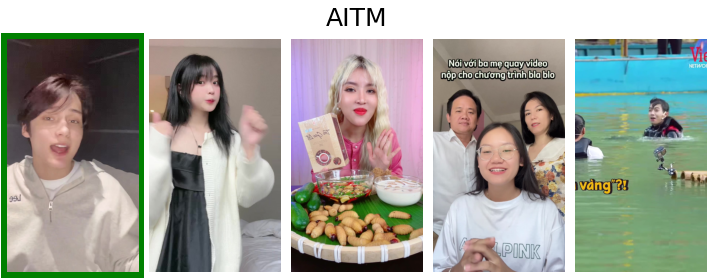

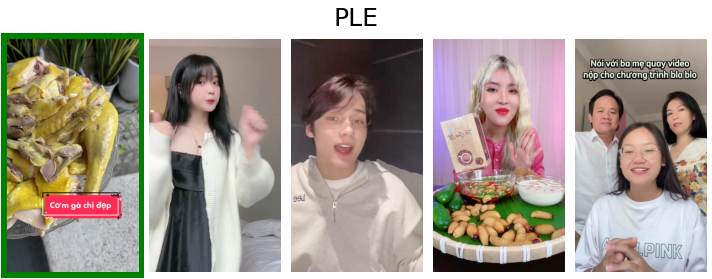

In [20]:
run_adaptive_beam_search('AITM')
run_adaptive_beam_search('PLE')

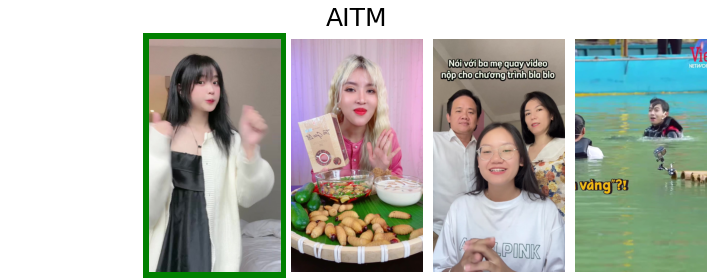

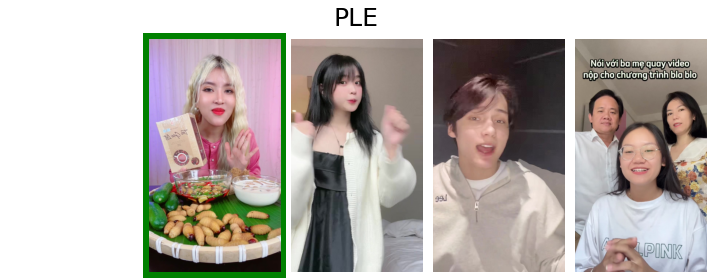

In [21]:
run_adaptive_beam_search('AITM')
run_adaptive_beam_search('PLE')

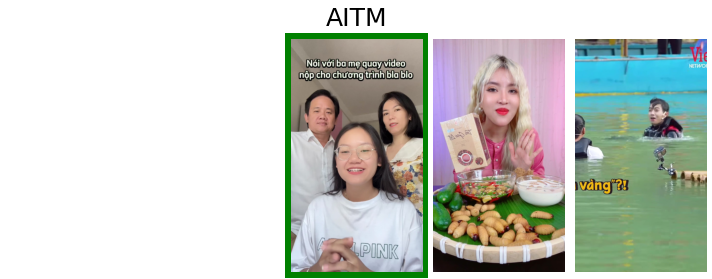

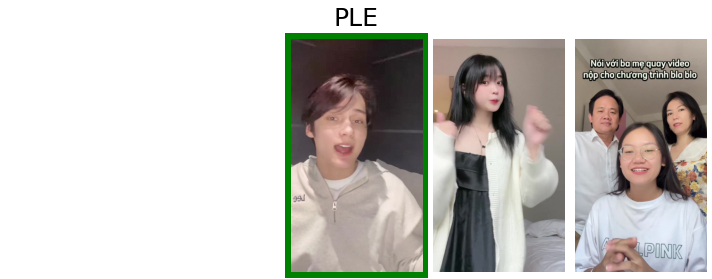

In [22]:
run_adaptive_beam_search('AITM')
run_adaptive_beam_search('PLE')

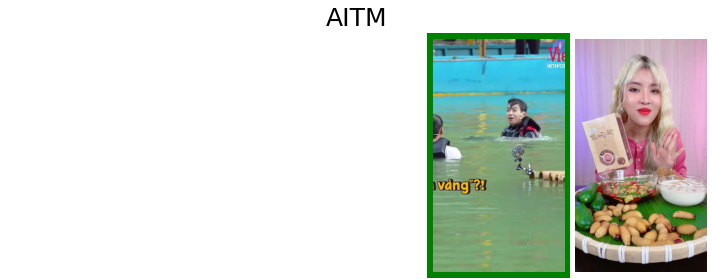

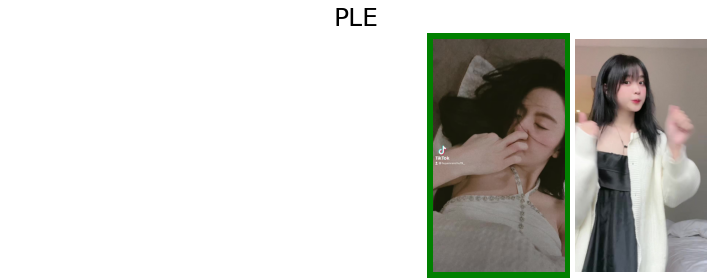

In [23]:
run_adaptive_beam_search('AITM')
run_adaptive_beam_search('PLE')

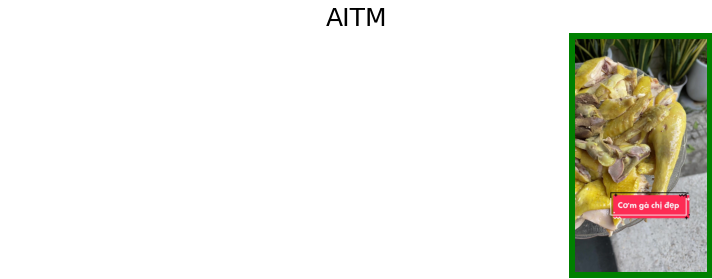

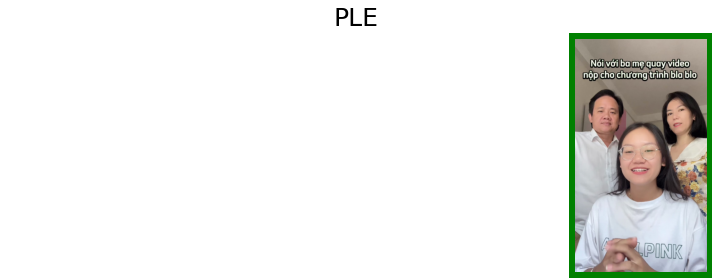

In [24]:
run_adaptive_beam_search('AITM')
run_adaptive_beam_search('PLE')

# Train

##MetaHeac

[Learning to Expand Audience via Meta Hybrid Experts and Critics for Recommendation and Advertising](https://easezyc.github.io/data/kdd21_metaheac.pdf) (KDD 2021)

In [ ]:
%cd /content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
!python main.py --model_name metaheac --dataset_name my_dataset --learning_rate 0.0001 --batch_size 128

/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
Getting dataset...
Dataset loaded!
Getting model...
Model: MetaHeac
Model loaded!
Start training...
100% 20/20 [00:20<00:00,  1.00s/it]
100% 7/7 [00:00<00:00, 17.51it/s]
epoch: 0 test: auc: [0.5122253199189597, 0.46007259528130673, 0.5146141197799187]
task 0, AUC 0.5122253199189597, Log-loss 0.48698980117340324
task 1, AUC 0.46007259528130673, Log-loss 2.2065573913811027
task 2, AUC 0.5146141197799187, Log-loss 0.9651416181361447
100% 20/20 [00:29<00:00,  1.46s/it]
100% 7/7 [00:00<00:00,  9.84it/s]
epoch: 1 test: auc: [0.5257493636253442, 0.5243799153055051, 0.5223269810485486]
task 0, AUC 0.5257493636253442, Log-loss 0.4811383125668704
task 1, AUC 0.5243799153055051, Log-loss 2.1322049591334116
task 2, AUC 0.5223269810485486, Log-loss 0.9396741860729503
100% 20/20 [00:28<00:00,  1.42s/it]
100% 7/7 [00:00<00:00,  9.96it/s]
epoch: 2 test: auc: [0.5369097300386154, 0.5348457350272232, 0.5432020363851002]
task 0, 

In [ ]:
%cd /content/Short-Video-Recommendation
!python adaptive_beam_search_parse_args.py --model_name "metaheac" --model_path "/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library/results/my_dataset_metaheac.pt" --test_set_path "dataset/final_input/final_test.csv"

/content/Short-Video-Recommendation
Model: MetaHeac
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
MRR: 0.765922619047619


##PLE

[Progressive Layered Extraction (PLE): A Novel Multi-Task Learning (MTL) Model for Personalized Recommendations](https://dl.acm.org/doi/pdf/10.1145/3383313.3412236?casa_token=8fchWD8CHc0AAAAA:2cyP8EwkhIUlSFPRpfCGHahTddki0OEjDxfbUFMkXY5fU0FNtkvRzmYloJtLowFmL1en88FRFY4Q) (RecSys 2020 best paper)

In [ ]:
%cd /content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
!python main.py --model_name ple --dataset_name my_dataset  --learning_rate 0.0001 --batch_size 128

/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
Getting dataset...
Dataset loaded!
Getting model...
Model: PLE
Model loaded!
Start training...
100% 20/20 [00:07<00:00,  2.54it/s]
100% 7/7 [00:00<00:00, 10.85it/s]
epoch: 0 test: auc: [0.5137751303052867, 0.5746521476104053, 0.5211675485380609]
task 0, AUC 0.5137751303052867, Log-loss 0.6802778009689833
task 1, AUC 0.5746521476104053, Log-loss 0.6206959214635587
task 2, AUC 0.5211675485380609, Log-loss 0.6828969984207433
100% 20/20 [00:08<00:00,  2.47it/s]
100% 7/7 [00:00<00:00, 10.82it/s]
epoch: 1 test: auc: [0.5195890837936588, 0.5139140955837871, 0.5328356557117861]
task 0, AUC 0.5195890837936588, Log-loss 0.66066963156042
task 1, AUC 0.5139140955837871, Log-loss 0.5787833118968391
task 2, AUC 0.5328356557117861, Log-loss 0.6805386409012619
100% 20/20 [00:07<00:00,  2.59it/s]
100% 7/7 [00:00<00:00, 10.67it/s]
epoch: 2 test: auc: [0.4873114685968589, 0.5264367816091954, 0.5274047684297068]
task 0, AUC 0.4873

In [ ]:
%cd /content/Short-Video-Recommendation
!python adaptive_beam_search_parse_args.py --model_name "ple" --model_path "/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library/results/my_dataset_ple.pt" --test_set_path "dataset/final_input/final_test.csv"

/content/Short-Video-Recommendation
Model: PLE
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
MRR: 0.7671052631578946


##AITM

[Modeling the Sequential Dependence among Audience Multi-step Conversions with Multi-task Learning in Targeted Display Advertising](https://dl.acm.org/doi/pdf/10.1145/3447548.3467071?casa_token=5YtVOYjJClUAAAAA:eVczwdynmE9dwoyElCG4da9fC5gsRiyX6zKt0_mIJF1K8NkU-SlNkGmpAu0c0EHbM3hBUe3zZc-o) (KDD 2021)

In [ ]:
%cd /content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
!python main.py --model_name aitm --dataset_name my_dataset  --learning_rate 0.0001 --batch_size 128

/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
Getting dataset...
Dataset loaded!
Getting model...
Model: AITM
Model loaded!
Start training...
100% 20/20 [00:01<00:00, 10.03it/s]
100% 7/7 [00:00<00:00, 32.96it/s]
epoch: 0 test: auc: [0.4808654695319399, 0.44373865698729587, 0.5247407087294728]
task 0, AUC 0.4808654695319399, Log-loss 0.7376900993463561
task 1, AUC 0.44373865698729587, Log-loss 0.6526015425693868
task 2, AUC 0.5247407087294728, Log-loss 0.6804776891010014
100% 20/20 [00:01<00:00, 10.11it/s]
100% 7/7 [00:00<00:00, 29.95it/s]
epoch: 1 test: auc: [0.4792810265112816, 0.5459165154264972, 0.5226669055800325]
task 0, AUC 0.4792810265112816, Log-loss 0.7323670753846688
task 1, AUC 0.5459165154264972, Log-loss 0.5945141584318051
task 2, AUC 0.5226669055800325, Log-loss 0.6746600057062335
100% 20/20 [00:02<00:00,  9.92it/s]
100% 7/7 [00:00<00:00, 28.94it/s]
epoch: 2 test: auc: [0.49093490796377426, 0.5789473684210527, 0.5280582667537999]
task 0, AUC 

In [ ]:
%cd /content/Short-Video-Recommendation
!python adaptive_beam_search_parse_args.py --model_name "aitm" --model_path "/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library/results/my_dataset_aitm.pt" --test_set_path "dataset/final_input/final_test.csv"

/content/Short-Video-Recommendation
Model: AITM
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
MRR: 0.7678260869565218


##MMoE

[Modeling Task Relationships in Multi-task Learning with Multi-Gate Mixture-of-Experts](https://dl.acm.org/doi/pdf/10.1145/3219819.3220007) (KDD 2018)

In [ ]:
%cd /content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
!python main.py --model_name mmoe --dataset_name my_dataset  --learning_rate 0.0001 --batch_size 128

/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
Getting dataset...
Dataset loaded!
Getting model...
Model: MMoE
Model loaded!
Start training...
100% 20/20 [00:04<00:00,  4.94it/s]
100% 7/7 [00:00<00:00, 20.22it/s]
epoch: 0 test: auc: [0.4703284905366327, 0.5039927404718694, 0.5068907182157387]
task 0, AUC 0.4703284905366327, Log-loss 0.6328153789244567
task 1, AUC 0.5039927404718694, Log-loss 0.6693620270430304
task 2, AUC 0.5068907182157387, Log-loss 0.6826878849446304
100% 20/20 [00:04<00:00,  4.87it/s]
100% 7/7 [00:00<00:00, 19.15it/s]
epoch: 1 test: auc: [0.4577568442743598, 0.5966727162734422, 0.49316725340978557]
task 0, AUC 0.4577568442743598, Log-loss 0.5865677262418584
task 1, AUC 0.5966727162734422, Log-loss 0.6345924783007769
task 2, AUC 0.49316725340978557, Log-loss 0.6800020540759587
100% 20/20 [00:04<00:00,  5.00it/s]
100% 7/7 [00:00<00:00, 19.34it/s]
epoch: 2 test: auc: [0.4643024121629812, 0.5925589836660617, 0.5006798490629677]
task 0, AUC 0

In [ ]:
%cd /content/Short-Video-Recommendation
!python adaptive_beam_search_parse_args.py --model_name "mmoe" --model_path "/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library/results/my_dataset_mmoe.pt" --test_set_path "dataset/final_input/final_test.csv"

/content/Short-Video-Recommendation
Model: MMoE
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

MRR: 0.7757309941520468


##MMoE + AutoDis

[Modeling Task Relationships in Multi-task Learning with Multi-Gate Mixture-of-Experts](https://dl.acm.org/doi/pdf/10.1145/3219819.3220007) (KDD 2018)

In [ ]:
%cd /content/Short-Video-Recommendation
!mkdir results
!mkdir results/autodis
!python train_MMOE_AT.py -ad -sav_mod "./results/autodis"

/content/Short-Video-Recommendation
cpu
Train on 2280 samples, validate on 254 samples, 18 steps per epoch
0it [00:00, ?it/s]tcmalloc: large alloc 1581719552 bytes == 0xe234000 @  0x7f2ea6ebbb6b 0x7f2ea6edb379 0x7f2e1d67b935 0x7f2e1d659093 0x7f2e4a72653f 0x7f2e4a727360 0x7f2e4a7273b4 0x7f2e4a7274ff 0x7f2e4b81f14b 0x7f2e4b877e22 0x7f2e4a78b5af 0x7f2e4a78e9c3 0x7f2e4a78febd 0x7f2e4b84e19a 0x7f2e4b84e200 0x7f2e4b1d757e 0x7f2e4cbd05ee 0x7f2e4cbd1023 0x7f2e4b2325b1 0x7f2e731733ad 0x7f2e73173497 0x4f9336 0x47c416 0x4e833c 0x5ddb8b 0x656b0c 0x517cd0 0x55e6a5 0x5d8868 0x4fe318 0x5d8506
tcmalloc: large alloc 1581719552 bytes == 0x1094e000 @  0x7f2ea6ebbb6b 0x7f2ea6edb379 0x7f2e1d67b935 0x7f2e1d659093 0x7f2e4a72653f 0x7f2e4a727360 0x7f2e4a7273b4 0x7f2e4a7274ff 0x7f2e4b81f14b 0x7f2e4b877e22 0x7f2e4a78b5af 0x7f2e4a78e9c3 0x7f2e4a78febd 0x7f2e4b84e19a 0x7f2e4b84e200 0x7f2e4b1d757e 0x7f2e4cbd05ee 0x7f2e4cbd1023 0x7f2e4b2325b1 0x7f2e4df7a67f 0x7f2e4cafc854 0x7f2e4d658a7b 0x7f2e4d652368 0x7f2e4d652ed8

In [ ]:
%cd /content/Short-Video-Recommendation
!python adaptive_beam_search_parse_args.py --model_name "temp" --model_path "/content/MMOE_AutoDis.pth" --test_set_path "dataset/final_input/final_test.csv"

/content/Short-Video-Recommendation
MRR: 0.769174041297935


##MMoE + AutoDis + Transformers

[Modeling Task Relationships in Multi-task Learning with Multi-Gate Mixture-of-Experts](https://dl.acm.org/doi/pdf/10.1145/3219819.3220007) (KDD 2018)

In [ ]:
%cd /content/Short-Video-Recommendation
!mkdir results/autodis_transformer
!python train_MMOE_AT.py -ad -tx -sav_mod "./results/autodis_tranformer"

/content/Short-Video-Recommendation
mkdir: cannot create directory ‘results’: File exists
cpu
Train on 2280 samples, validate on 254 samples, 18 steps per epoch
0it [00:00, ?it/s]tcmalloc: large alloc 1581719552 bytes == 0xf026000 @  0x7efd1b353b6b 0x7efd1b373379 0x7efc91b10935 0x7efc91aee093 0x7efcbebbb53f 0x7efcbebbc360 0x7efcbebbc3b4 0x7efcbebbc4ff 0x7efcbfcb414b 0x7efcbfd0ce22 0x7efcbec205af 0x7efcbec239c3 0x7efcbec24ebd 0x7efcbfce319a 0x7efcbfce3200 0x7efcbf66c57e 0x7efcc10655ee 0x7efcc1066023 0x7efcbf6c75b1 0x7efce76083ad 0x7efce7608497 0x4f9336 0x47c416 0x4e833c 0x5ddb8b 0x656b0c 0x517cd0 0x55e6a5 0x5d8868 0x4fe318 0x5d8506
tcmalloc: large alloc 1581719552 bytes == 0x114e0000 @  0x7efd1b353b6b 0x7efd1b373379 0x7efc91b10935 0x7efc91aee093 0x7efcbebbb53f 0x7efcbebbc360 0x7efcbebbc3b4 0x7efcbebbc4ff 0x7efcbfcb414b 0x7efcbfd0ce22 0x7efcbec205af 0x7efcbec239c3 0x7efcbec24ebd 0x7efcbfce319a 0x7efcbfce3200 0x7efcbf66c57e 0x7efcc10655ee 0x7efcc1066023 0x7efcbf6c75b1 0x7efcc240f67f 0x7ef

In [ ]:
%cd /content/Short-Video-Recommendation
!python adaptive_beam_search_parse_args.py --model_name "temp" --model_path "/content/MMOE_AT.pth" --test_set_path "dataset/final_input/final_test.csv"

/content/Short-Video-Recommendation
MRR: 0.7697368421052632


##OMoE

[Adaptive Mixtures of Local Experts](https://ieeexplore.ieee.org/abstract/document/6797059) (Neural Computation 1991)

In [ ]:
%cd /content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
!python main.py --model_name omoe --dataset_name my_dataset  --learning_rate 0.0001 --batch_size 128

/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library
Getting dataset...
Dataset loaded!
Getting model...
Model: OMoE
Model loaded!
Start training...
100% 20/20 [00:03<00:00,  5.13it/s]
100% 7/7 [00:00<00:00, 19.87it/s]
epoch: 0 test: auc: [0.4412543940154808, 0.5527525710828796, 0.48942544848957564]
task 0, AUC 0.4412543940154808, Log-loss 0.6656741386088799
task 1, AUC 0.5527525710828796, Log-loss 0.6816126710920688
task 2, AUC 0.48942544848957564, Log-loss 0.6969321776763929
100% 20/20 [00:03<00:00,  5.13it/s]
100% 7/7 [00:00<00:00, 19.94it/s]
epoch: 1 test: auc: [0.4537740913262567, 0.5218390804597701, 0.5215074730695449]
task 0, AUC 0.4537740913262567, Log-loss 0.6448128920790182
task 1, AUC 0.5218390804597701, Log-loss 0.564589966955952
task 2, AUC 0.5215074730695449, Log-loss 0.6879332152743173
100% 20/20 [00:03<00:00,  5.15it/s]
100% 7/7 [00:00<00:00, 20.32it/s]
epoch: 2 test: auc: [0.4857097092590348, 0.528009679370841, 0.5205430360267302]
task 0, AUC 0.4

In [ ]:
%cd /content/Short-Video-Recommendation
!python adaptive_beam_search_parse_args.py --model_name "omoe" --model_path "/content/Short-Video-Recommendation/models/Multitask-Recommendation-Library/results/my_dataset_omoe.pt" --test_set_path "dataset/final_input/final_test.csv"

/content/Short-Video-Recommendation
Model: OMoE
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
MRR: 0.7625730994152047
